In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from dpks import QuantMatrix

In [2]:
ms_data = pd.read_csv(
    "../0_data/proteins_train_filtered.tsv"
    , sep="\t"
)

In [3]:
design_matrix_otrain = pd.read_csv(
    "../0_data/design_matrix_train.tsv",
    sep='\t'
)

In [4]:
# abdominal_infection
# blood_stream_infection
# abdominal_infection
# skin_and_soft_tissue_infection
# pneumonia

In [5]:
def preprocess_design_matrix(design_matrix):

    design_matrix = design_matrix[design_matrix['verified_infection'] == 1]

    design_matrix = design_matrix[
        (design_matrix['urinary_tract_infection'] == 1) |
        #(design_matrix['blood_stream_infection'] == 1) |
        (design_matrix['abdominal_infection'] == 1) |
        (design_matrix['skin_and_soft_tissue_infection'] == 1) |
        (design_matrix['pneumonia'] == 1)
    ]

    design_matrix['group'] = np.where(
        design_matrix['abdominal_infection'] == 1, 2, 1
    )

    design_matrix['sample'] = design_matrix['injection']

    return design_matrix

In [6]:
def preprocess_data(raw_data, design_matrix):

    quant_matrix = QuantMatrix(
        quantification_file=raw_data[['Protein'] + [sample for sample in design_matrix['sample'].values]].copy(),
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    quant_data = quant_matrix.to_df()
    
    quant_data = quant_data[~((quant_data["ProteinLabel"].str.startswith("HV")) | (quant_data["ProteinLabel"].str.startswith("LV")) | quant_data["ProteinLabel"].str.startswith("KV"))]
    quant_data = quant_data[~quant_data["ProteinLabel"].str.startswith("IG")]
    quant_data = quant_data[~((quant_data["ProteinLabel"] == "HBA_HUMAN") | (quant_data["ProteinLabel"] == "HBB_HUMAN") | (quant_data["ProteinLabel"] == "HBD_HUMAN") | (quant_data["ProteinLabel"] == "HEMO_HUMAN"))]


    quant_matrix = QuantMatrix(
        quantification_file=quant_data,
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    return quant_matrix     


# Model Training

In [7]:
design_matrix_train = preprocess_design_matrix(design_matrix_otrain.copy())

<Axes: xlabel='abdominal_infection', ylabel='Count'>

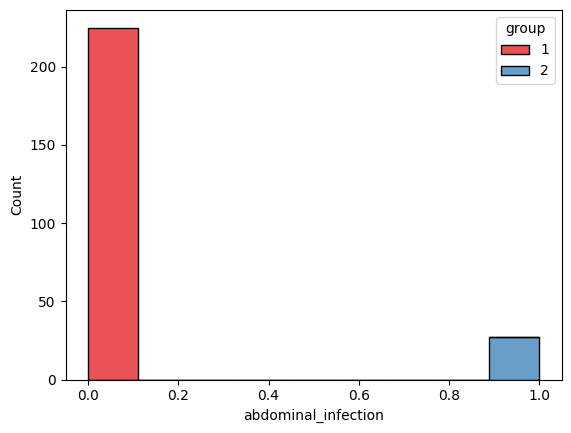

In [8]:
sns.histplot(
    design_matrix_train,
    x="abdominal_infection",
    hue="group",
    palette="Set1",
    multiple="stack"
)

In [9]:
design_matrix_train['group'].value_counts()

group
1    225
2     27
Name: count, dtype: int64

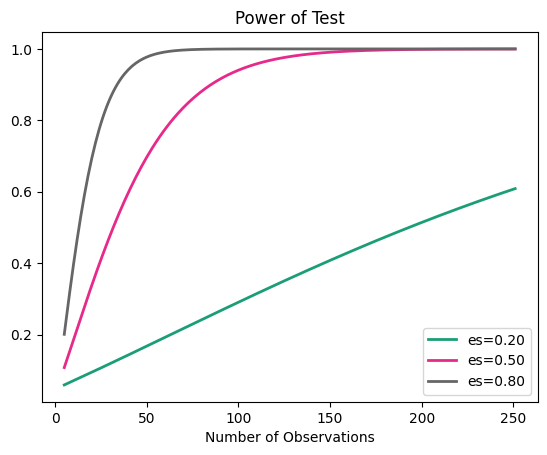

In [10]:
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt

# parameters for power analysis
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, design_matrix_train.shape[0]))


analysis = TTestIndPower()

analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

In [11]:
quant_matrix_train = preprocess_data(ms_data, design_matrix=design_matrix_train)

In [12]:
quant_matrix_train = quant_matrix_train.compare(
    method="linregress",
    comparisons=(2,1),
    min_samples_per_group=2,
    level="protein",
    multiple_testing_correction_method="fdr_tsbh"
)

In [13]:
quant_matrix_train.write("de_results/abdominal_de_proteins.tsv")

In [14]:
quant_matrix_de = quant_matrix_train.to_df()

<Axes: xlabel='Log2FoldChange2-1', ylabel='-Log10CorrectedPValue2-1'>

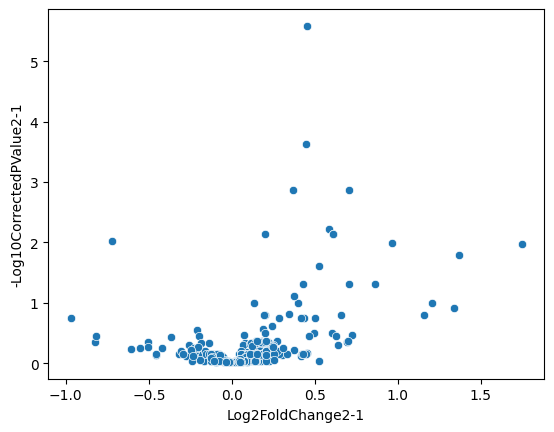

In [15]:
sns.scatterplot(
    data=quant_matrix_de,
    x="Log2FoldChange2-1",
    y="-Log10CorrectedPValue2-1"
)

In [16]:
qm_filtered = (
    
    QuantMatrix(
        quantification_file=quant_matrix_de,
        design_matrix_file=design_matrix_train
    )
    
)

In [17]:
training_data, y = qm_filtered.to_ml(feature_column="ProteinLabel")

In [18]:
protein_columns = training_data.columns.to_list()

In [19]:
len(protein_columns)

287

In [20]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer

X = training_data.copy()

protein_scaler = StandardScaler()

X[protein_columns] = protein_scaler.fit_transform(X[protein_columns])

X = X.copy()

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier


protein_clf = LogisticRegression(
    random_state=42,
    #penalty="l1",
    class_weight="balanced",
    #C=0.1,
    #solver="liblinear",
    max_iter=1000
)

# protein_clf = BaggingClassifier(
#     estimator=protein_clf
# )

In [22]:
y['label'].value_counts()

label
0    225
1     27
Name: count, dtype: int64

In [23]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight


class_weight = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y.values.ravel()),
    y=y.values.ravel()
)

class_weight = dict(zip(np.unique(y.values.ravel()), class_weight))

class_weight

{0: 0.56, 1: 4.666666666666667}

In [24]:
# sample_weight = compute_sample_weight(
#     class_weight=class_weight,
#     y=y.values.ravel()
# )

In [25]:
from mrmr import mrmr_classif
selected_proteins = mrmr_classif(X=X[protein_columns], y=y.values.ravel(), K=50)

100%|██████████| 50/50 [00:20<00:00,  2.43it/s]


In [26]:
selected_proteins

['BGH3_HUMAN',
 'FLNA_HUMAN',
 'PSPB_HUMAN',
 'TLN1_HUMAN',
 'CAMP_HUMAN',
 'FHR4_HUMAN',
 'HS90A_HUMAN',
 'A1BG_HUMAN',
 'AMPN_HUMAN',
 'ICAM1_HUMAN',
 'BIP_HUMAN',
 'ENPL_HUMAN',
 'ALDOB_HUMAN',
 'PIGR_HUMAN',
 'ANT3_HUMAN',
 'CATD_HUMAN',
 'ITB3_HUMAN',
 'LAMP1_HUMAN',
 'CSPG2_HUMAN',
 'ENOA_HUMAN',
 'SHBG_HUMAN',
 'CALR_HUMAN',
 'SAA4_HUMAN',
 'VWF_HUMAN',
 'TSP1_HUMAN',
 'PCSK9_HUMAN',
 'CMGA_HUMAN',
 'NCHL1_HUMAN',
 'FUCO_HUMAN',
 'CATB_HUMAN',
 'ATRN_HUMAN',
 'TIMP1_HUMAN',
 'ITA2B_HUMAN',
 'FCG3A_HUMAN',
 'LDHA_HUMAN',
 'HRG_HUMAN',
 'CADH1_HUMAN',
 'PRG4_HUMAN',
 'COL10_HUMAN',
 'A2MG_HUMAN',
 'H4_HUMAN',
 'CNDP1_HUMAN',
 'MRC1_HUMAN',
 'CXCL7_HUMAN',
 'CRIS3_HUMAN',
 'MBL2_HUMAN',
 'GSTO1_HUMAN',
 'FBLN5_HUMAN',
 'APOF_HUMAN',
 'PLTP_HUMAN']

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, HistGradientBoostingClassifier


protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [28]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3)
eval_result = cross_validate(
    protein_clf, X[selected_proteins], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.5185185185185185,
 0.3534382284382285,
 0.8452380952380952,
 0.7014814814814815)

In [29]:
from dpks.interpretation import BootstrapInterpreter

protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_proteins,
    downsample_background=True,
    shuffle_iterations=100
)

In [30]:
protein_interpreter.fit(X[selected_proteins].values, y.values.ravel(), protein_clf)

In [31]:
protein_importances = protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [32]:
protein_importances.head(20)

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
0,BGH3_HUMAN,1.000000,1.0,0.461163,17.0,0.457427,13.0,0.721870,5.0,0.542000,...,0.681912,3.0,0.263873,29.0,0.608171,0.610690,0.277688,10.92,6.5,10.917209
37,PRG4_HUMAN,0.367782,18.0,0.992595,2.0,0.227510,28.0,0.520258,10.0,0.902110,...,1.000000,1.0,0.805959,3.0,0.575831,0.552651,0.260280,11.62,8.0,10.567513
16,ITB3_HUMAN,0.290050,26.0,0.138730,37.0,0.393604,16.0,0.969046,2.0,0.580331,...,0.084449,39.0,0.290183,26.0,0.568221,0.541440,0.303797,13.78,9.0,13.682976
6,HS90A_HUMAN,0.457882,15.0,0.252985,27.0,0.701954,4.0,1.000000,1.0,0.582034,...,0.229741,22.0,0.344202,20.0,0.502992,0.467598,0.221904,13.70,11.5,9.262175
20,SHBG_HUMAN,0.122949,39.0,0.976176,3.0,0.239620,27.0,0.927069,3.0,0.682711,...,0.507383,7.0,0.097470,41.0,0.474616,0.439019,0.278662,16.43,12.0,13.715180
8,AMPN_HUMAN,0.039167,47.0,1.000000,1.0,0.438772,15.0,0.578895,7.0,0.411830,...,0.564792,6.0,0.356624,18.0,0.465243,0.477883,0.211222,15.04,13.0,10.743022
34,LDHA_HUMAN,0.315714,21.0,0.840349,6.0,0.468867,12.0,0.195437,27.0,0.068622,...,0.269603,19.0,1.000000,1.0,0.462297,0.411718,0.308429,18.20,16.0,14.337209
2,PSPB_HUMAN,0.969816,3.0,0.664206,10.0,0.005079,50.0,0.224598,24.0,0.838747,...,0.703973,2.0,0.119120,37.0,0.420720,0.362156,0.289051,19.82,14.0,15.386850
43,CXCL7_HUMAN,0.695205,7.0,0.531090,13.0,0.487543,10.0,0.212045,25.0,0.420872,...,0.054030,43.0,0.725638,7.0,0.405849,0.396003,0.257062,20.37,18.0,13.813809
10,BIP_HUMAN,0.170504,32.0,0.158207,35.0,0.845416,3.0,0.415468,12.0,0.475257,...,0.149809,29.0,0.349813,19.0,0.393136,0.363724,0.229697,19.90,18.0,12.505756


In [33]:
selected_proteins = protein_importances.head(10)['feature'].to_list()

In [34]:
from dpks.interpretation import Classifier


protein_clf = Classifier(protein_clf)

In [35]:
selected_features = selected_proteins[:10]

In [36]:
for feature in selected_features:

    print(feature)

BGH3_HUMAN
PRG4_HUMAN
ITB3_HUMAN
HS90A_HUMAN
SHBG_HUMAN
AMPN_HUMAN
LDHA_HUMAN
PSPB_HUMAN
CXCL7_HUMAN
BIP_HUMAN


In [37]:
protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [38]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[selected_features], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, 
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.6296296296296297,
 0.33816425120772947,
 0.8293650793650794,
 0.7414814814814815)

In [39]:
cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[protein_columns], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, 
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.3703703703703704,
 0.44642857142857145,
 0.8849206349206349,
 0.6585185185185185)

In [40]:
from dpks.interpretation import BootstrapInterpreter

final_protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_features,
    downsample_background=True,
    shuffle_iterations=100
)

In [41]:
final_protein_interpreter.fit(X[selected_features].values, y.values.ravel(), protein_clf)

In [42]:
final_protein_importances = final_protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [43]:
final_protein_importances

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
9,BIP_HUMAN,0.691890,3.0,0.524747,4.0,0.983277,2.0,0.324743,7.0,1.000000,...,0.960669,2.0,0.780055,2.0,0.750895,0.778784,0.215163,3.06,3.0,1.905971
3,HS90A_HUMAN,0.763218,2.0,0.360030,7.0,1.000000,1.0,1.000000,1.0,0.639828,...,0.415532,8.0,0.375780,8.0,0.655423,0.635194,0.237827,4.06,4.0,2.356251
2,ITB3_HUMAN,0.325884,7.0,0.052915,10.0,0.715888,5.0,0.992081,2.0,0.982879,...,0.090796,10.0,0.608095,3.0,0.655343,0.684369,0.294581,4.20,4.0,2.781614
0,BGH3_HUMAN,0.611222,5.0,0.468272,5.0,0.755345,4.0,0.530803,5.0,0.319088,...,0.768437,4.0,0.455647,6.0,0.591767,0.597321,0.261824,4.77,5.0,2.639464
6,LDHA_HUMAN,0.680734,4.0,0.410731,6.0,0.392812,6.0,0.270800,9.0,0.367910,...,0.133265,9.0,1.000000,1.0,0.508294,0.522374,0.291918,5.66,6.0,2.885771
5,AMPN_HUMAN,0.237598,8.0,1.000000,1.0,0.291689,7.0,0.533713,4.0,0.487429,...,0.751930,5.0,0.490250,4.0,0.467978,0.445513,0.243858,6.19,7.0,2.423350
7,PSPB_HUMAN,1.000000,1.0,0.712747,2.0,0.183720,9.0,0.410262,6.0,0.608447,...,1.000000,1.0,0.114468,10.0,0.450892,0.421627,0.274561,6.21,6.0,2.793553
8,CXCL7_HUMAN,0.606154,6.0,0.203702,9.0,0.799781,3.0,0.182253,10.0,0.191778,...,0.437054,7.0,0.478466,5.0,0.443808,0.419885,0.254720,6.50,7.0,2.540580
4,SHBG_HUMAN,0.223332,9.0,0.239603,8.0,0.267720,8.0,0.652338,3.0,0.380938,...,0.453920,6.0,0.222359,9.0,0.362962,0.329979,0.237866,7.11,8.0,2.534190
1,PRG4_HUMAN,0.167158,10.0,0.577392,3.0,0.101601,10.0,0.271906,8.0,0.731140,...,0.899034,3.0,0.407910,7.0,0.362390,0.325131,0.253510,7.24,8.0,2.550975


In [44]:
final_protein_importances.to_csv(
    "feature_importances/abdominal_protein_importances.tsv",
    sep="\t",
    index=False
)

# Model Testing

In [45]:
ms_data_test = pd.read_csv(
    "../0_data/proteins_test_filtered.tsv"
    , sep="\t"
)
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

In [46]:
design_matrix_test = preprocess_design_matrix(design_matrix_test)

quant_matrix_test = preprocess_data(ms_data_test, design_matrix=design_matrix_test)

In [47]:
quant_matrix_test_df = quant_matrix_test.to_df()
#quant_matrix_test_df = quant_matrix_test_df[quant_matrix_test_df['ProteinLabel'].isin(selected_features)]

In [48]:
qm_filtered_test = (
    
    QuantMatrix(
        quantification_file=quant_matrix_test_df,
        design_matrix_file=design_matrix_test
    )
    
)

In [49]:
testing_data, y_test = qm_filtered_test.to_ml(feature_column="ProteinLabel")

In [50]:
X_test = testing_data.copy()

X_test[protein_scaler.feature_names_in_] = protein_scaler.transform(X_test[protein_scaler.feature_names_in_])

X_test = X_test.copy()

In [51]:
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

decision_tree = DecisionTreeClassifier(random_state=42)

random_forest = RandomForestClassifier(random_state=42)

svc = SVC(random_state=42)
knn = KNeighborsClassifier()
naive_bayes = GaussianNB()
mlp = MLPClassifier(random_state=42)


lr_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)



# lr_clf = GradientBoostingClassifier(
#     #estimator=random_forest,
#     random_state=42
# )

xgb_clf = XGBClassifier(
    max_depth=5,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    learning_rate=0.01,
    n_estimators=1000,
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    n_jobs=1
)




In [52]:
lr_clf.fit(X[selected_features], y.values.ravel(), )
xgb_clf.fit(X[selected_features], y.values.ravel(), )
decision_tree.fit(X[selected_features], y.values.ravel(), ) 
random_forest.fit(X[selected_features], y.values.ravel(), )
svc.fit(X[selected_features], y.values.ravel(), )
knn.fit(X[selected_features], y.values.ravel()) 
naive_bayes.fit(X[selected_features], y.values.ravel(), ) 
mlp.fit(X[selected_features], y.values.ravel())

MLPClassifier(random_state=42)

In [53]:
from sklearn.metrics import f1_score

lr_predictions = lr_clf.predict(X_test[selected_features])
lr_ba = f1_score(y_test.values.ravel(), lr_predictions)

xgb_predictions = xgb_clf.predict(X_test[selected_features])
xgb_ba = f1_score(y_test.values.ravel(), xgb_predictions)

decision_tree_predictions = decision_tree.predict(X_test[selected_features])
decision_tree_ba = f1_score(y_test.values.ravel(), decision_tree_predictions)

rf_predictions = random_forest.predict(X_test[selected_features])
rf_ba = f1_score(y_test.values.ravel(), rf_predictions)

svc_predictions = svc.predict(X_test[selected_features])
svc_ba = f1_score(y_test.values.ravel(), svc_predictions)

knn_predictions = knn.predict(X_test[selected_features])
knn_ba = f1_score(y_test.values.ravel(), knn_predictions)

nb_predictions = naive_bayes.predict(X_test[selected_features])
nb_ba = f1_score(y_test.values.ravel(), nb_predictions)

mlp_predictions = mlp.predict(X_test[selected_features])
mlp_ba = f1_score(y_test.values.ravel(), mlp_predictions)

In [54]:
lr_ba, xgb_ba, decision_tree_ba, rf_ba, svc_ba, knn_ba, nb_ba, mlp_ba

(0.2647058823529412,
 0.08333333333333333,
 0.2857142857142857,
 0.2222222222222222,
 0.0,
 0.08695652173913043,
 0.15,
 0.08)

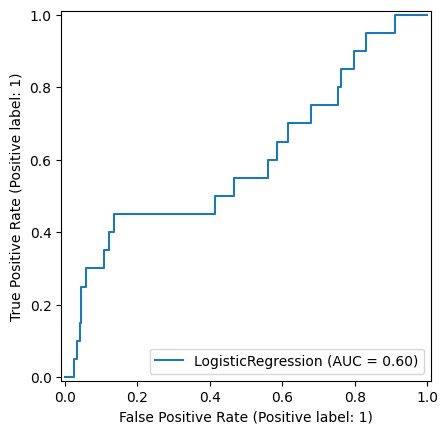

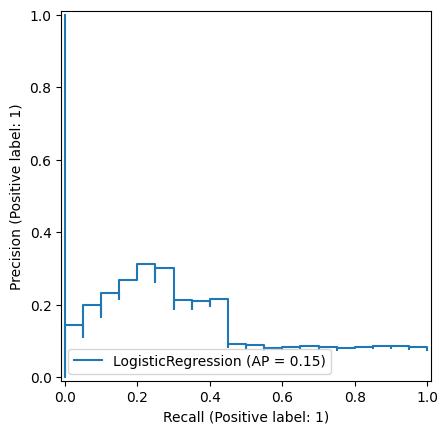

In [55]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)


PrecisionRecallDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)





In [56]:
from sklearn.metrics import roc_curve

y_probs = lr_clf.predict_proba(X_test[selected_features])[:, 1]

# Compute ROC curve metrics
fpr, tpr, thresholds = roc_curve( y_test.values.ravel(), y_probs)

# Create a DataFrame to store the metrics
roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Threshold': thresholds
})


In [57]:
roc_df.to_csv(
    "roc/abdominal.tsv",
    sep="\t"
)

# Probability Prediction

In [58]:
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

design_matrix_test['sample'] = design_matrix_test['injection']
design_matrix_test['group'] = 1

quant_matrix_predict = QuantMatrix(
    quantification_file=ms_data_test,
    design_matrix_file=design_matrix_test,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
).impute(method="uniform_percentile", percentile=0.01)

predict_data, y_test_alll = quant_matrix_predict.to_ml(feature_column="ProteinLabel")

In [59]:
predict_data = predict_data[protein_columns].copy()

In [60]:
predict_data[protein_columns] = protein_scaler.transform(predict_data[protein_columns])

In [61]:
predict_data['abdominal_probability'] = lr_clf.predict_proba(predict_data[selected_features])[:, 1]

In [62]:
design_matrix_test = design_matrix_test.set_index("injection").join(
    predict_data['abdominal_probability']
).reset_index()

In [63]:
predict_data[['abdominal_probability']].to_csv(
    "predictions_test/abdominal.tsv",
    sep="\t"
)

<Axes: xlabel='abdominal_probability', ylabel='Count'>

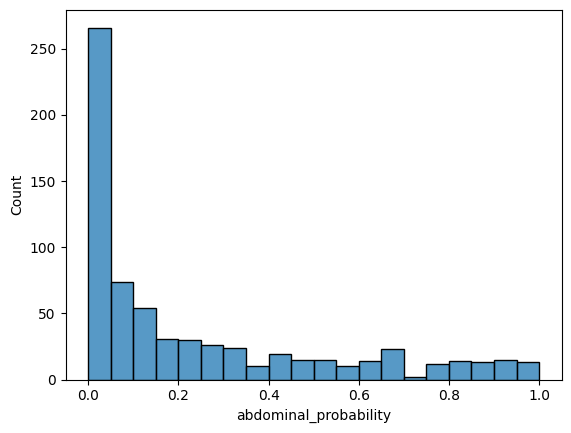

In [64]:
sns.histplot(
    data=design_matrix_test,
    x="abdominal_probability",
    #hue="sofa_abdominal_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [65]:
ms_data_val = pd.read_csv(
    "../0_data/proteins_val_filtered.tsv"
    , sep="\t"
)

design_matrix_val = pd.read_csv(
    "../0_data/design_matrix_validation.tsv",
    sep='\t'
)

design_matrix_val['sample'] = design_matrix_val['injection']
design_matrix_val['group'] = 1

quant_matrix_val = QuantMatrix(
    quantification_file=ms_data_val,
    design_matrix_file=design_matrix_val,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

val_data, y_val = quant_matrix_val.to_ml(feature_column="ProteinLabel")

In [66]:
val_data = val_data[protein_columns].copy()

In [67]:
val_data[protein_columns] = protein_scaler.transform(val_data[protein_columns])

In [68]:
val_data['abdominal_probability'] = lr_clf.predict_proba(val_data[selected_features])[:, 1]

In [69]:
design_matrix_val = design_matrix_val.set_index("injection").join(
    val_data['abdominal_probability']
).reset_index()

In [70]:
val_data[['abdominal_probability']].to_csv(
    "predictions_val/abdominal.tsv",
    sep="\t"
)

<Axes: xlabel='abdominal_probability', ylabel='Count'>

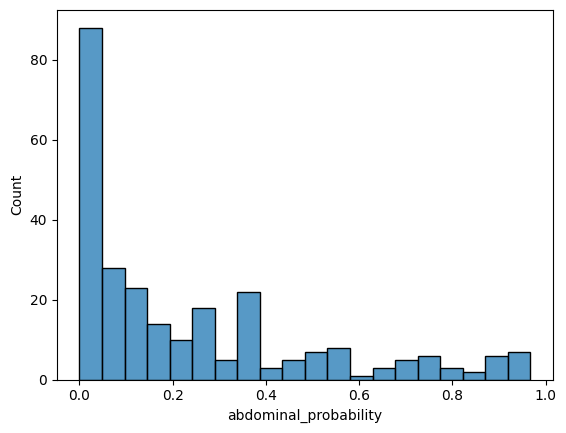

In [71]:
sns.histplot(
    data=design_matrix_val,
    x="abdominal_probability",
    #hue="sofa_abdominal_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [72]:
ms_data_hero = pd.read_csv(
    "../0_data/proteins_hero_filtered.tsv"
    , sep="\t"
)

design_matrix_hero = pd.read_csv(
    "../0_data/design_matrix_hero.tsv",
    sep='\t'
)

design_matrix_hero['sample'] = design_matrix_hero['injection']
design_matrix_hero['group'] = 1

quant_matrix_hero = QuantMatrix(
    quantification_file=ms_data_hero,
    design_matrix_file=design_matrix_hero,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

hero_data, y_hero = quant_matrix_hero.to_ml(feature_column="ProteinLabel")

In [73]:
hero_data = hero_data[protein_columns].copy()

In [74]:
hero_data[protein_columns] = protein_scaler.transform(hero_data[protein_columns])

In [75]:
hero_data['abdominal_probability'] = lr_clf.predict_proba(hero_data[selected_features])[:, 1]

In [76]:
design_matrix_hero = design_matrix_hero.set_index("injection").join(
    hero_data['abdominal_probability']
).reset_index()

In [77]:
hero_data[['abdominal_probability']].to_csv(
    "predictions_external/abdominal.tsv",
    sep="\t"
)

<Axes: xlabel='abdominal_probability', ylabel='Count'>

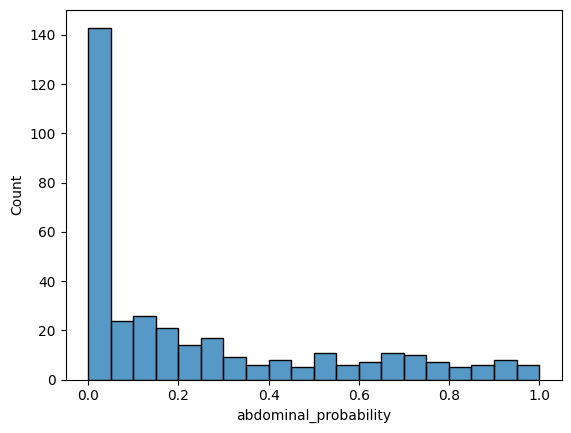

In [78]:
sns.histplot(
    data=hero_data,
    x="abdominal_probability",
    #hue="sofa_abdominal_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [79]:
from joblib import dump


with open("models/abdominal_protein_model.pkl", "wb") as f:

    dump(lr_clf, f)

with open("models/abdominal_protein_scaler.pkl", "wb") as f:

    dump(protein_scaler, f)
